In [38]:

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

torch.cuda.empty_cache()


True
NVIDIA GeForce RTX 2060


In [39]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

# ---------------------------
# Datasets and Generator
# ---------------------------


SPECTROGRAM_DIR = r"D:\Music-Classification\dataset\Data\images_original"
CSV_DIR = r"D:\Music-Classification\resnet\data"
TRAIN_CSV = os.path.join(CSV_DIR, "train.csv")
VAL_CSV = os.path.join(CSV_DIR, "valid.csv")
TEST_CSV = os.path.join(CSV_DIR, "test.csv")

train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Label map
def build_label_map(df):
    labels = sorted(df['genre'].unique())
    return {label: idx for idx, label in enumerate(labels)}

label_map = build_label_map(train_df)
inv_label_map = {v: k for k, v in label_map.items()}
num_classes = len(label_map)


class SpectrogramDataset(Dataset):
    def __init__(self, df, label_map, img_root, transform=None):
        self.df = df
        self.label_map = label_map
        self.img_root = img_root
        self.transform = transform
        self.classes = sorted(label_map.keys())
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row['file_name'] 
        genre = row['genre']

  
        base, ext = os.path.splitext(file_name)  
        genre_name, number = base.split('.')     
        fname = f"{genre_name}{int(number):05d}.png"  
        img_path = os.path.join(self.img_root, genre_name, fname)

       
        image = Image.open(img_path).convert('RGB')
        label = self.label_map[genre]
        if self.transform:
            image = self.transform(image)
        return image, label

In [40]:
from torchvision import transforms
import random
import torchvision.transforms.functional as TF

class RandomApplySpecAugment:

    def __init__(self, time_mask_param=40, freq_mask_param=15, p=0.5):
        self.time_mask_param = time_mask_param
        self.freq_mask_param = freq_mask_param
        self.p = p

    def __call__(self, img):
        if random.random() > self.p:
            return img

        img = TF.to_tensor(img)
        c, h, w = img.shape
        # Time masking (vertical rectangles)
        t = random.randint(0, self.time_mask_param)
        t0 = random.randint(0, w - t) if w - t > 0 else 0
        img[:, :, t0:t0 + t] = 0

        # Frequency masking (horizontal rectangles)
        f = random.randint(0, self.freq_mask_param)
        f0 = random.randint(0, h - f) if h - f > 0 else 0
        img[:, f0:f0 + f, :] = 0
        img = TF.to_pil_image(img)
        return img


def fixed_center_crop(img, left=54, top=35, right=42, bottom=35):
    w, h = img.size
    return img.crop((left, top, w - right, h - bottom))


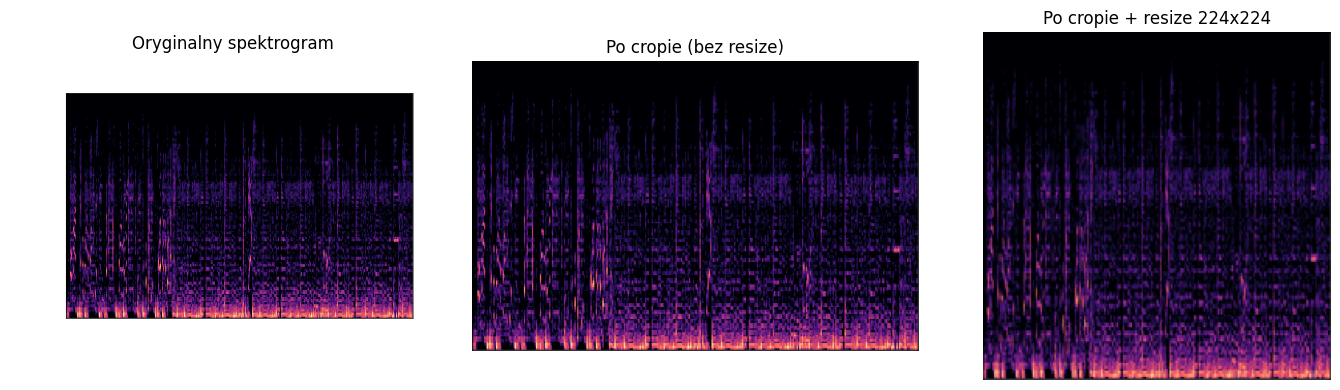

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = r"D:\Music-Classification\dataset\Data\images_original\metal\metal00099.png"
img = Image.open(img_path)

cropped_img = fixed_center_crop(img, left=54, top=35, right=42, bottom=35)
cropped_resized = cropped_img.resize((224, 224))
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Oryginalny spektrogram")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cropped_img)
plt.title("Po cropie (bez resize)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cropped_resized)
plt.title("Po cropie + resize 224x224")
plt.axis('off')

plt.tight_layout()
plt.show()


In [42]:
from torchvision import transforms

#Augmentation
train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: fixed_center_crop(img, left=54, top=35, right=42, bottom=35)),
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1)], p=0.6),
    transforms.RandomAffine(degrees=5, translate=(0.04, 0.02), scale=(0.96, 1.04), shear=1, fill=0),
    RandomApplySpecAugment(time_mask_param=40, freq_mask_param=18, p=0.7),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.06), ratio=(0.4, 2.2), value=0)
])


data_transforms = transforms.Compose([
    transforms.Lambda(lambda img: fixed_center_crop(img, left=54, top=35, right=42, bottom=35)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ]) backup

batch_size = 32

# train_dataset = SpectrogramDataset(train_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)
# val_dataset = SpectrogramDataset(val_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)
# test_dataset = SpectrogramDataset(test_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)

#Augmentacja
train_dataset = SpectrogramDataset(train_df, label_map, SPECTROGRAM_DIR, transform=train_transforms)
val_dataset = SpectrogramDataset(val_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)
test_dataset = SpectrogramDataset(test_df, label_map, SPECTROGRAM_DIR, transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [43]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

base_name = "GPU_resnet50_imagenet_bath32_30_Adam1e-4_dropout0.8_1_augment_resize_fit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Premade PyTorch (Meta) ResNet50
# ---------------------------
#model = models.resnet50(weights=None)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(nn.Dropout(0.8),nn.Linear(model.fc.in_features, num_classes)) # Dropout 
#model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(512, num_classes)) # ReLU + Dropout
#model.fc = nn.Linear(model.fc.in_features, num_classes) #basic
model = model.to(device)

# ---------------------------
# ResNet18
# ---------------------------

# model = models.resnet18(weights=None)  
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4) 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)#  weight_decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

In [44]:
import torch
import numpy as np
import copy
from sklearn.metrics import precision_score
import pickle
import heapq

def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    num_epochs=30, patience=10, base_name="model"
):
    

    patience_counter = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': []
    }

    top_models = []  

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, running_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / running_total
        train_acc = running_corrects.double().item() / running_total
        train_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)

        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        val_preds, val_labels_list = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = val_corrects.double().item() / val_total
        val_prec = precision_score(val_labels_list, val_preds, average='macro', zero_division=0)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, prec: {train_prec:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, prec: {val_prec:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)

        save_name = f"{base_name}_ep{epoch+1}_valacc{val_acc:.4f}.pt"
        checkpoint = (val_acc, save_name, copy.deepcopy(model.state_dict()), epoch+1)
        heapq.heappush(top_models, checkpoint)
        if len(top_models) > 3:
            removed = heapq.heappop(top_models)
            print(f"[ModelCheckpoint] Removed from top models: {removed[1]} (val_acc={removed[0]:.4f}, epoch {removed[3]})")
        print(f"[ModelCheckpoint] Candidate model saved at epoch {epoch+1} with val_acc={val_acc:.4f} as {save_name}")

        best_acc = max([m[0] for m in top_models])
        patience_counter = 0 if val_acc == best_acc else patience_counter + 1

        if patience_counter >= patience:
            print("[EarlyStopping] Patience exceeded. Stopping training.")
            break

    top_models_sorted = sorted(top_models, reverse=True)  # Best first
    for i, (acc, fname, weights, epoch_num) in enumerate(top_models_sorted):
        torch.save(weights, fname)
        print(f"[ModelCheckpoint] Top model #{i+1} saved: {fname} (val_acc={acc:.4f}, epoch {epoch_num})")

    model.load_state_dict(top_models_sorted[0][2])
    return model, history, top_models_sorted



In [45]:
# # ---------------------------
# # Compile and Train
# # ---------------------------

model, history, top_models = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=15
)

with open(f"{base_name}.pkl", 'wb') as f:
    pickle.dump(history, f)


Epoch 1/30 | Train loss: 2.2552, acc: 0.1931, prec: 0.1896 | Val loss: 1.6646, acc: 0.4400, prec: 0.3405
[ModelCheckpoint] Candidate model saved at epoch 1 with val_acc=0.4400 as model_ep1_valacc0.4400.pt
Epoch 2/30 | Train loss: 1.7248, acc: 0.3877, prec: 0.3664 | Val loss: 1.2316, acc: 0.6267, prec: 0.6166
[ModelCheckpoint] Candidate model saved at epoch 2 with val_acc=0.6267 as model_ep2_valacc0.6267.pt
Epoch 3/30 | Train loss: 1.3094, acc: 0.5522, prec: 0.5428 | Val loss: 1.0671, acc: 0.6067, prec: 0.6316
[ModelCheckpoint] Candidate model saved at epoch 3 with val_acc=0.6067 as model_ep3_valacc0.6067.pt
Epoch 4/30 | Train loss: 1.0434, acc: 0.6509, prec: 0.6425 | Val loss: 0.8682, acc: 0.7400, prec: 0.7743
[ModelCheckpoint] Removed from top models: model_ep1_valacc0.4400.pt (val_acc=0.4400, epoch 1)
[ModelCheckpoint] Candidate model saved at epoch 4 with val_acc=0.7400 as model_ep4_valacc0.7400.pt
Epoch 5/30 | Train loss: 0.9116, acc: 0.7010, prec: 0.6999 | Val loss: 0.8327, acc: 0


==== Ewaluacja modelu model_ep19_valacc0.8133.pt (val_acc=0.8133, checkpoint z epoki 19) ====
Test Accuracy: 0.7867 | Precision: 0.7889 | Recall: 0.7867 | F1: 0.7855
[INFO] Model pochodzi z epoki 19


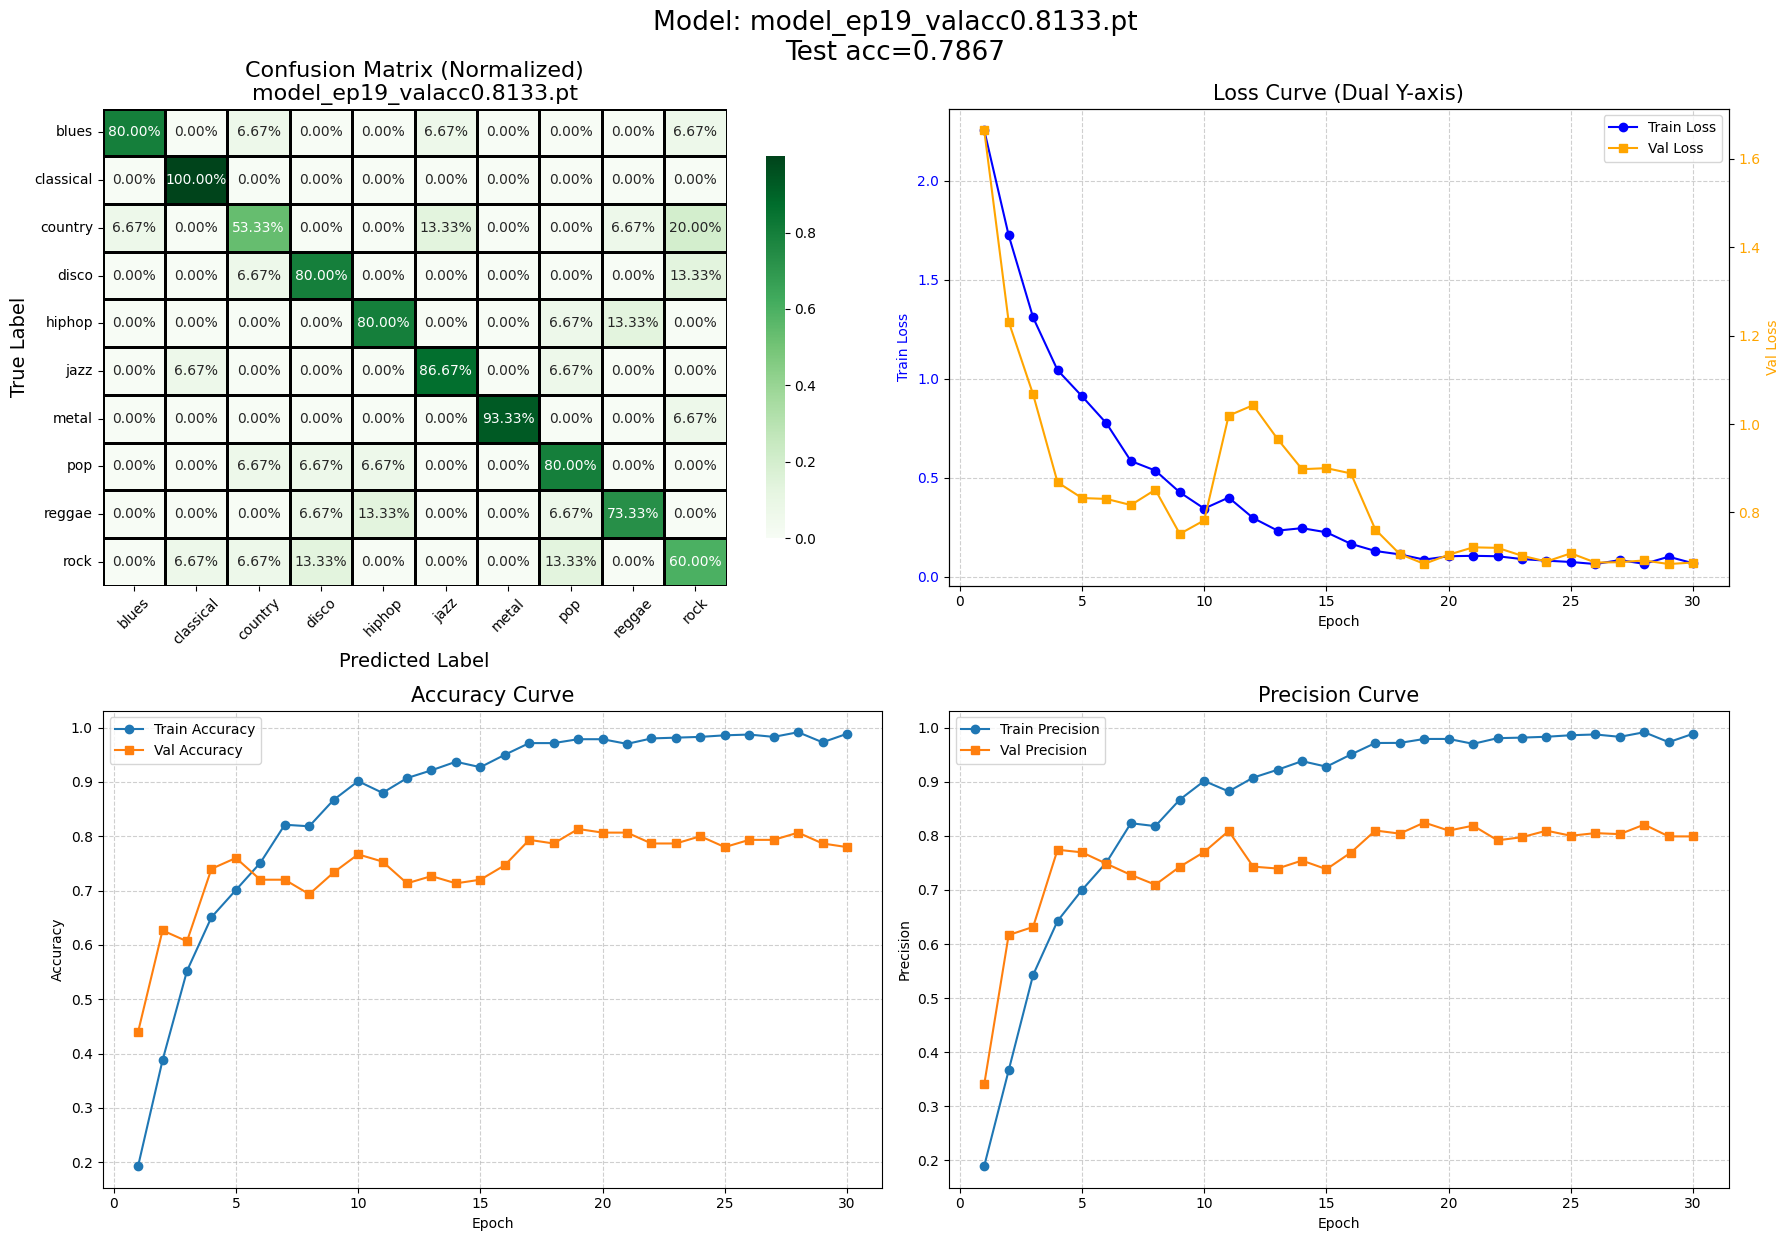


==== Ewaluacja modelu model_ep28_valacc0.8067.pt (val_acc=0.8067, checkpoint z epoki 28) ====
Test Accuracy: 0.7800 | Precision: 0.7834 | Recall: 0.7800 | F1: 0.7793
[INFO] Model pochodzi z epoki 28


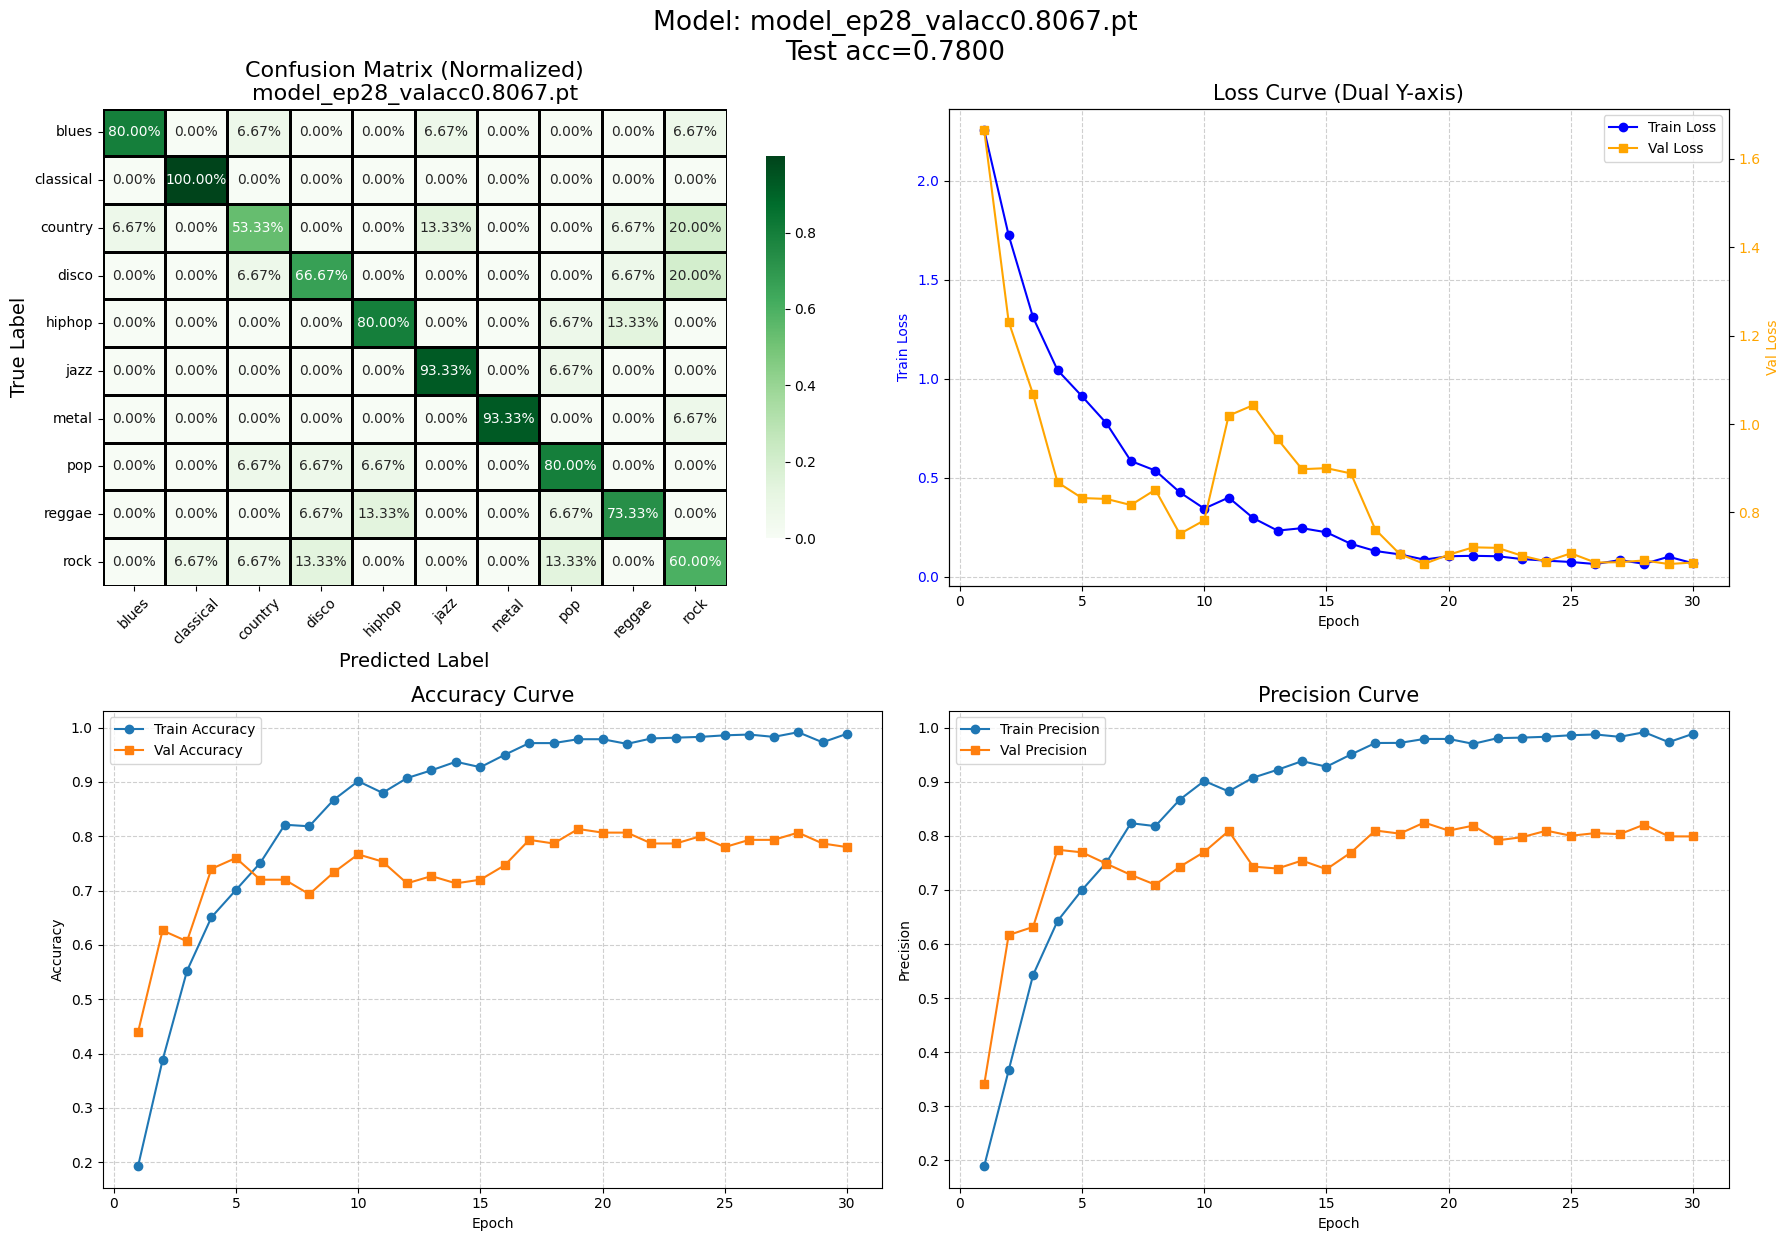


==== Ewaluacja modelu model_ep21_valacc0.8067.pt (val_acc=0.8067, checkpoint z epoki 21) ====
Test Accuracy: 0.7800 | Precision: 0.7838 | Recall: 0.7800 | F1: 0.7773
[INFO] Model pochodzi z epoki 21


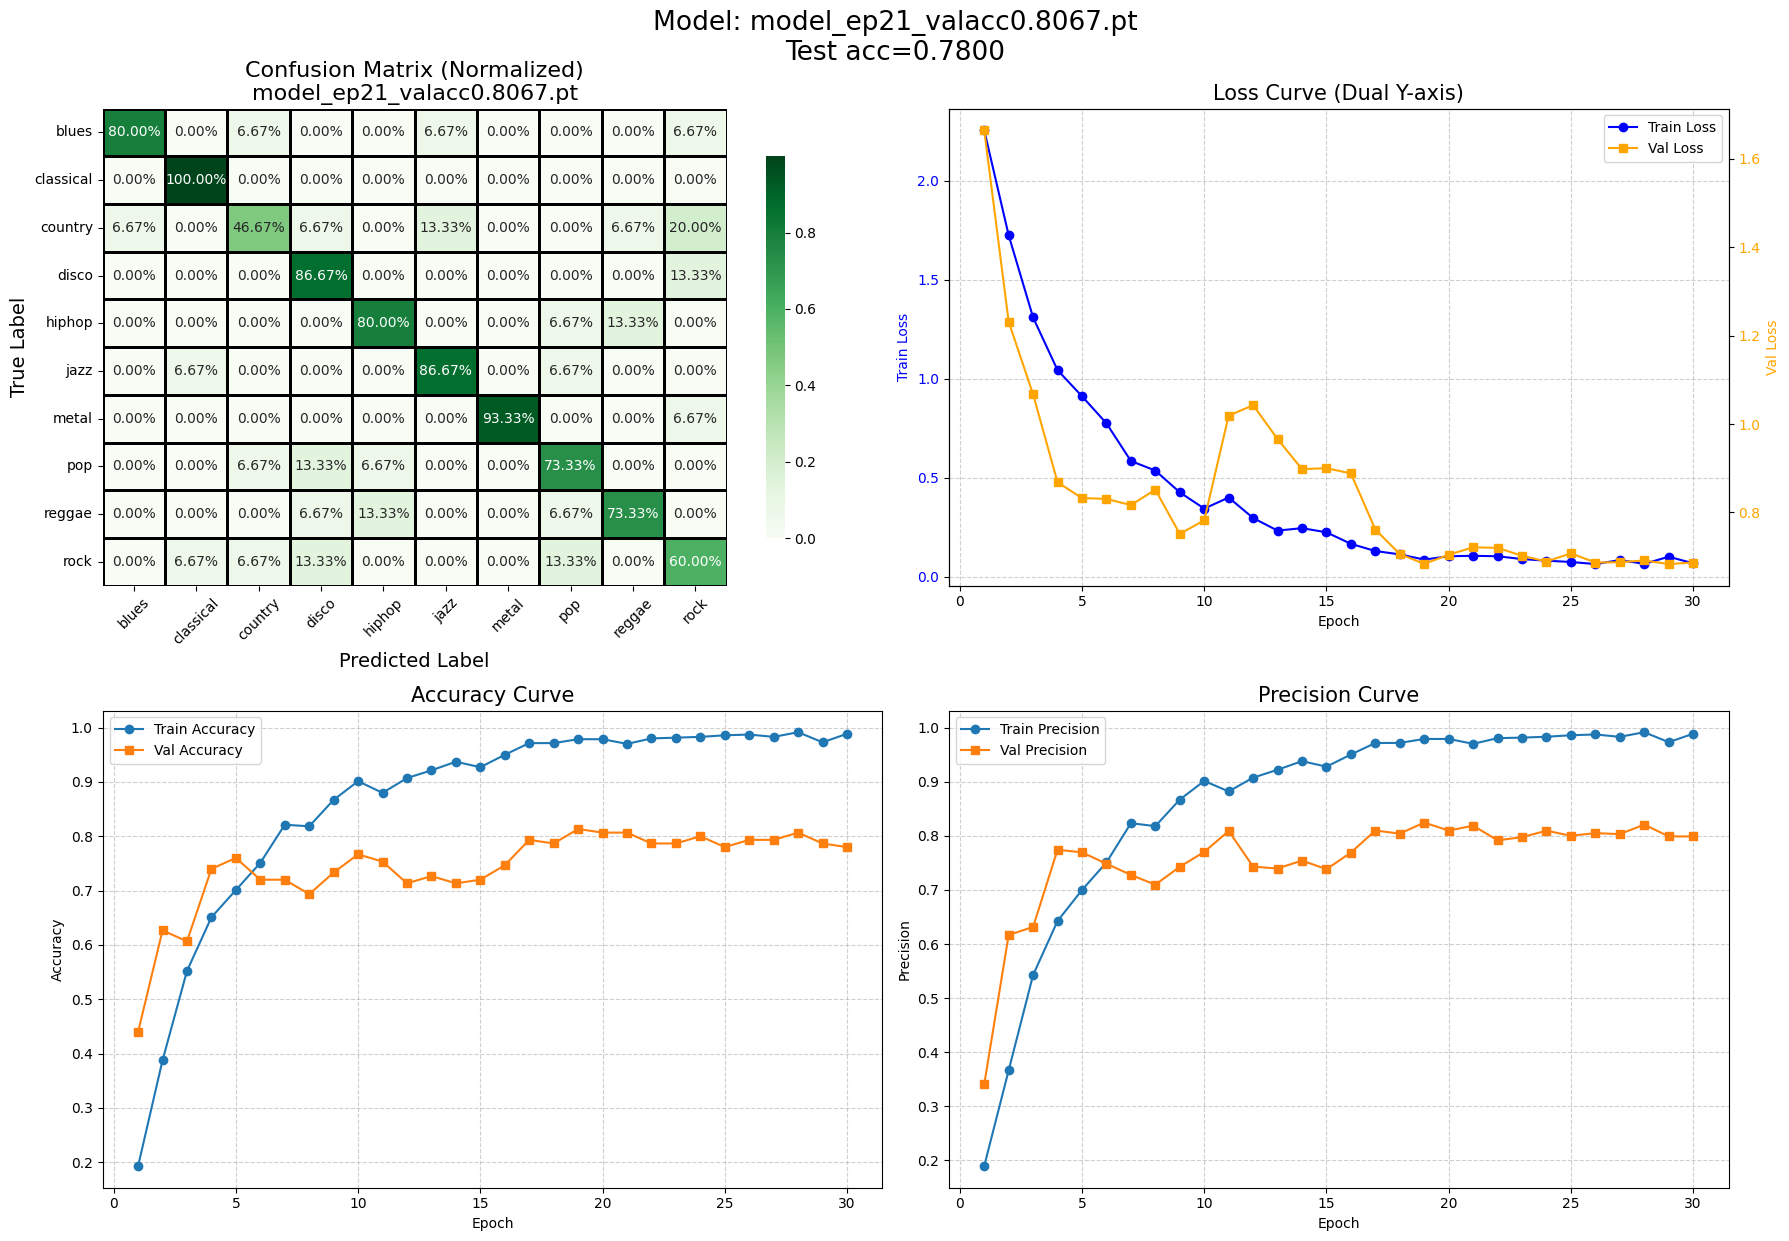

In [46]:
# # ---------------------------
# # Evaluate 
# # ---------------------------

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())
    return np.array(y_true), np.array(y_pred)
results = []

for i, (acc, fname, weights, epoch_num) in enumerate(top_models):
    print(f"\n==== Ewaluacja modelu {fname} (val_acc={acc:.4f}, checkpoint z epoki {epoch_num}) ====")
    model.load_state_dict(weights)
    y_true, y_pred = evaluate_model(model, test_loader)

    test_accuracy = accuracy_score(y_true, y_pred)
    test_precision = precision_score(y_true, y_pred, average='macro')
    test_f1 = f1_score(y_true, y_pred, average='macro')
    test_recall = recall_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}")
    print(f"[INFO] Model pochodzi z epoki {epoch_num}")

    results.append({
        'fname': fname, 'val_acc': acc,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'conf_matrix': conf_matrix,
        'y_true': y_true, 'y_pred': y_pred,
        'history': history
    })

# # ---------------------------
# # Plot
# # ---------------------------

    class_names = train_loader.dataset.classes
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    cm_norm = conf_matrix.astype('float') / (conf_matrix.sum(axis=1, keepdims=True) + 1e-8)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap="Greens",
                xticklabels=class_names, yticklabels=class_names,
                linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8},
                ax=axs[0, 0])
    axs[0, 0].set_xlabel('Predicted Label', fontsize=14)
    axs[0, 0].set_ylabel('True Label', fontsize=14)
    axs[0, 0].set_title(f'Confusion Matrix (Normalized)\n{fname}', fontsize=16)
    axs[0, 0].tick_params(axis='x', rotation=45)

    ax1 = axs[0, 1]
    line1, = ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('Loss Curve (Dual Y-axis)', fontsize=15)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2 = ax1.twinx()
    line2, = ax2.plot(epochs, history['val_loss'], 'orange', marker='s', label='Val Loss')
    ax2.set_ylabel('Val Loss', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    axs[1, 0].plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    axs[1, 0].plot(epochs, history['val_acc'], label='Val Accuracy', marker='s')
    axs[1, 0].set_title('Accuracy Curve', fontsize=15)
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, history['train_prec'], label='Train Precision', marker='o')
    axs[1, 1].plot(epochs, history['val_prec'], label='Val Precision', marker='s')
    axs[1, 1].set_title('Precision Curve', fontsize=15)
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.suptitle(f'Model: {fname}\nTest acc={test_accuracy:.4f}', fontsize=19, y=1.03)
    plt.show()


